In [1]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

model = create_res_net() # or create_plain_net()
model.summary()


timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)
 
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=128,
    callbacks=[cp_callback, tensorboard_callback]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


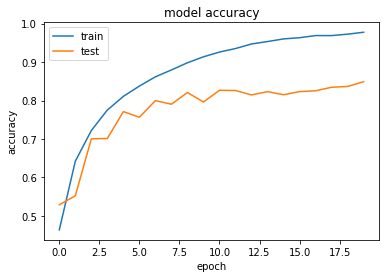

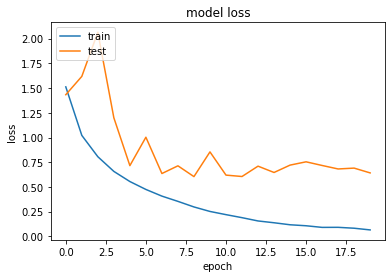

In [4]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
model.save('resnet.h5', 'extractor-model.h5')
print ("Model saved!")

Model saved!
